In [16]:
import sys; sys.path.append('../3rdparty/ElasticRods/python')
import elastic_rods, elastic_knots
import numpy as np, matplotlib.pyplot as plt, time, io, os

from helpers import *
from parametric_curves import *
import py_newton_optimizer

from linkage_vis import LinkageViewer as Viewer, CenterlineViewer
from tri_mesh_viewer import PointCloudViewer, PointCloudMesh

%load_ext autoreload
%autoreload 2

import parallelism
parallelism.set_max_num_tbb_threads(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
file = '../data/CubicLatticeKnots/L100/4_1.txt'
rod_radius = 0.2
material = elastic_rods.RodMaterial('ellipse', 2000, 0.3, [rod_radius, rod_radius])
centerline = read_nodes_from_file(file)  # supported formats: obj, txt
pr = define_periodic_rod(centerline, material)
rod_list = elastic_knots.PeriodicRodList([pr])

problemOptions = elastic_knots.ContactProblemOptions()
problemOptions.hasCollisions = True
problemOptions.contactStiffness = 1000
problemOptions.dHat = 2*rod_radius

contactProblem = elastic_knots.ContactProblem(rod_list,problemOptions)

print( f"Gradient length: {len(rod_list.gradient())},DoFs length: {len(rod_list.getDoFs())}")

Gradient length: 401,DoFs length: 401


In [18]:
view = Viewer(rod_list, width=1024, height=800)
view.show()

Renderer(camera=PerspectiveCamera(aspect=1.28, children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0),…

In [19]:
path = [rod_list.getDoFs()]
def callback(problem, iteration):
    if iteration % 10 == 0:
        path.insert(0,rod_list.getDoFs())
        view.update()
        
optimizerOptions = py_newton_optimizer.NewtonOptimizerOptions()
optimizerOptions.niter = 1000
optimizerOptions.gradTol = 1e-8
hessianShift = 1e-4 * compute_min_eigenval_straight_rod(pr)

fixedVars = []   # all the degrees of freedom can be modified by the optimizer

report = elastic_knots.compute_equilibrium(
        rod_list, problemOptions, optimizerOptions, 
        fixedVars=fixedVars,
        externalForces=np.zeros(rod_list.numDoF()),
        softConstraints=[],
        callback=callback,
        hessianShift=hessianShift
        )
view.update()

path =  path + path[-1::-1]
old_path = []
for p in path:
    old_path.append(p.copy)
print(np.array(path).shape)

0	286.381	163.068	163.068	1	1
1	234.619	85.5512	85.5512	1	1
2	190.161	59.4486	59.4486	1	1
3	144.298	44.2785	44.2785	1	1
4	106.602	36.3681	36.3681	1	1
5	79.3911	31.6995	31.6995	1	1
6	60.6783	25.4977	25.4977	1	1
7	46.7969	22.9182	22.9182	1	1
8	36.3347	52.6755	52.6755	1	1
9	35.0125	16.3351	16.3351	1	1
10	34.3487	7.28412	7.28412	1	1
11	33.709	4.91131	4.91131	1	1
12	32.8108	4.2154	4.2154	1	1
13	31.357	3.91523	3.91523	1	1
14	29.0866	4.13467	4.13467	1	1
15	25.8905	5.74788	5.74788	1	1
16	22.1674	8.71425	8.71425	1	1
17	18.6553	8.93598	8.93598	1	1
18	15.4913	8.98462	8.98462	0.09375	1
19	15.3353	8.15837	8.15837	0.203125	0
20	13.8857	9.98307	9.98307	0.75	0
21	11.3466	10.7378	10.7378	1	0
22	10.6371	68.2742	68.2742	1	1
23	8.86592	11.8485	11.8485	1	1
24	8.56457	3.72505	3.72505	1	1
25	8.41678	1.61873	1.61873	1	1
26	8.31227	0.962594	0.962594	1	1
27	8.18914	0.778605	0.778605	1	1
28	7.99942	0.721665	0.721665	1	1
29	7.71839	0.749967	0.749967	1	1
30	7.34551	0.921192	0.921192	1	1
31	6.90467	1.24996	1.24996	

In [20]:
def show_path(rod, path, view, wait=0.05):
    for DoFs in path:
        rod.setDoFs(DoFs)
        time.sleep(wait)
        view.update()
show_path(contactProblem,path,view)
print(np.linalg.norm(path[23]-path[24]))

1.7189024759908447


In [21]:
def getPathEnergy(path, rod, view):
    path_energy=[]
    for DoFs in path:
        rod.setDoFs(DoFs)
        path_energy.append(rod.energy())
        view.update()
    return path_energy
energy = getPathEnergy(path, contactProblem,view)

In [22]:
def getPathGradient(path, rod):
    path_gradient=[]
    for DoFs in path:
        rod.setDoFs(DoFs)
        path_gradient.append(rod.gradient())
    return path_gradient
path_gradient = getPathGradient(path, contactProblem)

In [23]:
def safe_normalize(v, eps=1e-12):
    norm = np.linalg.norm(v)
    if norm < eps or np.isnan(norm):
        return np.zeros_like(v)
    return v / norm

def getTangent(R_pre, R_next):
    t = R_next - R_pre
    t = safe_normalize(t)
    return np.array(t)

print(np.array(getTangent(path[0],path[2])).shape)

(401,)


In [24]:
# F_spring = k * (||R_{i+1} - R_i|| - ||R_i - R_{i-1}||) * tangent_i
def getSpringForce(R_pre,R, R_next):
    k = 1
    tangent = getTangent(R_pre, R_next)
    F = k*(np.linalg.norm(R_next-R)-np.linalg.norm(R-R_pre))*tangent
    return np.array(F)
print(np.array(getSpringForce(*path[:3])).shape)

(401,)


In [25]:
#F_perp =-d_R_{i} + d_R_{i}°tangent_i*tanget_i
def getPerpForce(d_R,R_pre, R_next):
    tangent = getTangent(R_pre, R_next)
    F= (-d_R + (np.dot(d_R,tangent) * tangent))
    return np.array(F)
print(np.array(getPerpForce(path_gradient[0], path[0],path[2])).shape)

(401,)


In [26]:
def getNEBForce(d_R,R_pre, R, R_next):
    return getPerpForce(d_R,R_pre, R_next) + getSpringForce(R_pre,R, R_next)

print(np.array(getNEBForce(path_gradient[0],*path[:3])).shape)
    

(401,)


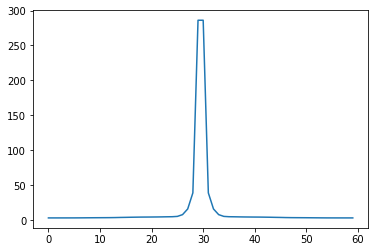

Path energy: 903.5953654614962


In [27]:
path_energy = getPathEnergy(path,contactProblem,view)
plt.plot(range(len(path_energy)),path_energy)

plt.show()
print(f"Path energy: {sum(path_energy)}")

In [13]:
def optimize_rod_path_dofs(R,rod, step_size=0.002, iterations=1000):
    for it in range(iterations):
        
        for i in range(1, len(R)-1):
            rod.setDoFs(R[i])
            d_R = rod.gradient()
            F = getNEBForce(d_R,R[i-1],R[i],R[i+1])
            R[i] += step_size * F
            
            
        max_force = max(np.linalg.norm(f) for f in F)
        if it % 100 ==0:
            print(f"{it} max force = {max_force}")
            
    print(f"{it} max force = {max_force}")
    return R    
new_path = optimize_rod_path_dofs(path, contactProblem, iterations=1000)

0 max force = 0.029671136570469693
100 max force = 0.006256950132956729
200 max force = 0.000870657748291272
300 max force = 0.0007605070203036923
400 max force = 0.0014842282502707436
500 max force = 0.003132929465112741
600 max force = 0.004470190795470849
700 max force = 0.005446529240272885
800 max force = 0.006125368183202098
900 max force = 0.006584037493162989
999 max force = 0.006879773144149698


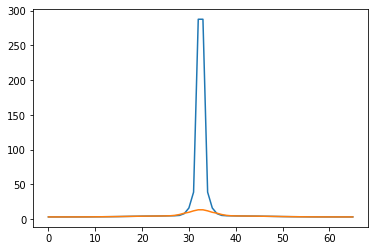

Path old energy: 926.7844371987727, Path new energy: 317.5664379477312
difference:  609.2179992510415


In [14]:
new_path_energy = getPathEnergy(new_path,contactProblem,view)
plt.plot(range(len(path_energy)),path_energy)
plt.plot(range(len(new_path_energy)),new_path_energy)
plt.show()
print(f"Path old energy: {sum(path_energy)}, Path new energy: {sum(new_path_energy)}")
print(f"difference:  {sum(path_energy)- sum(new_path_energy)}")

In [15]:
time.sleep(3)
show_path(rod_list,path,view)   
show_path(rod_list,new_path,view)   
